# MCMCシミュレーションコードのテスト

MCMCシミュレーションのコードを改良したため、ちゃんと動作しているかテスト。

## import

In [40]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import torch
import random

import mcmc_function as mcmc
import ising_model as ising
from ising_model import Ising_model
import QAOA_function as qaoa
from QAOA_function import QAOA_ansatz
import made

seed = 1454
rng = np.random.default_rng(seed)

## コードの改良

最後にacceptされた配置の情報を保持するように改良。

In [41]:
def ssf_update_new(init_spin, instance, beta, n_iter, rng=None):
	if rng == None:
		rng = np.random.default_rng()
    
	n_spin = init_spin.shape[0]
	state_history = np.zeros((n_iter+1, n_spin))
	state_history[0] = init_spin
	acceptance_history = np.zeros(n_iter)

	accept_state = init_spin

	for i in range(n_iter):
		# make a porposal
		flip_index = rng.integers(0, n_spin)
		proposal_state = mcmc.single_spin_flip(accept_state, flip_index)

		# accept or reject the proposal
		next_state, acceptance, flag = mcmc.boltzmann_metropolis(accept_state, proposal_state, instance, beta, rng)

		# update the accept_state
		state_history[i+1] = next_state
		acceptance_history[i] = acceptance
		if flag:
			accept_state = next_state
	
	return state_history, acceptance_history

## テスト

乱数rngを初期化して発生する遷移が同等の状態でテストする。

In [42]:
n_spin = 5
instance = Ising_model(n_spin, rng, type='SK')
beta = 1.0
n_iter = 100

### 旧version

In [43]:
rng = np.random.default_rng(seed)
init_state = ising.number_to_spin(rng.integers(0, 2**n_spin), n_spin)

state_history_1 = np.zeros((n_iter+1, n_spin))
state_history_1[0] = init_state

for i in range(n_iter):
	state_history_1[i+1] = mcmc.ssf_update(state_history_1[i], instance, beta, rng)[0]

### 新version

In [44]:
rng = np.random.default_rng(seed)
init_state = ising.number_to_spin(rng.integers(0, 2**n_spin), n_spin)

state_history_2 = ssf_update_new(init_state, instance, beta, n_iter, rng)[0]

### 確認

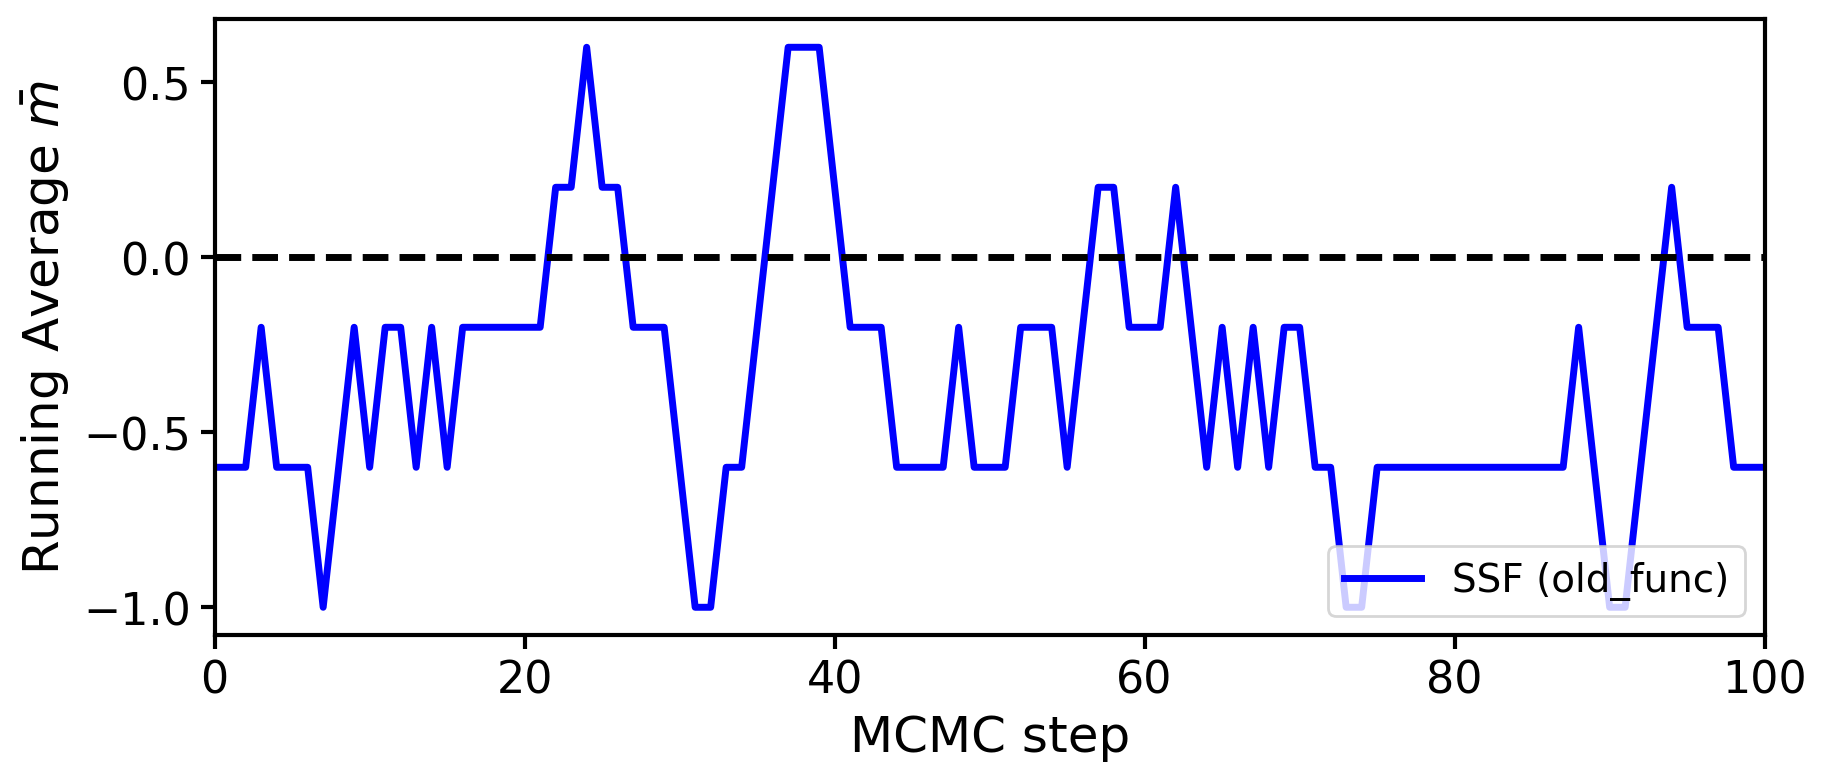

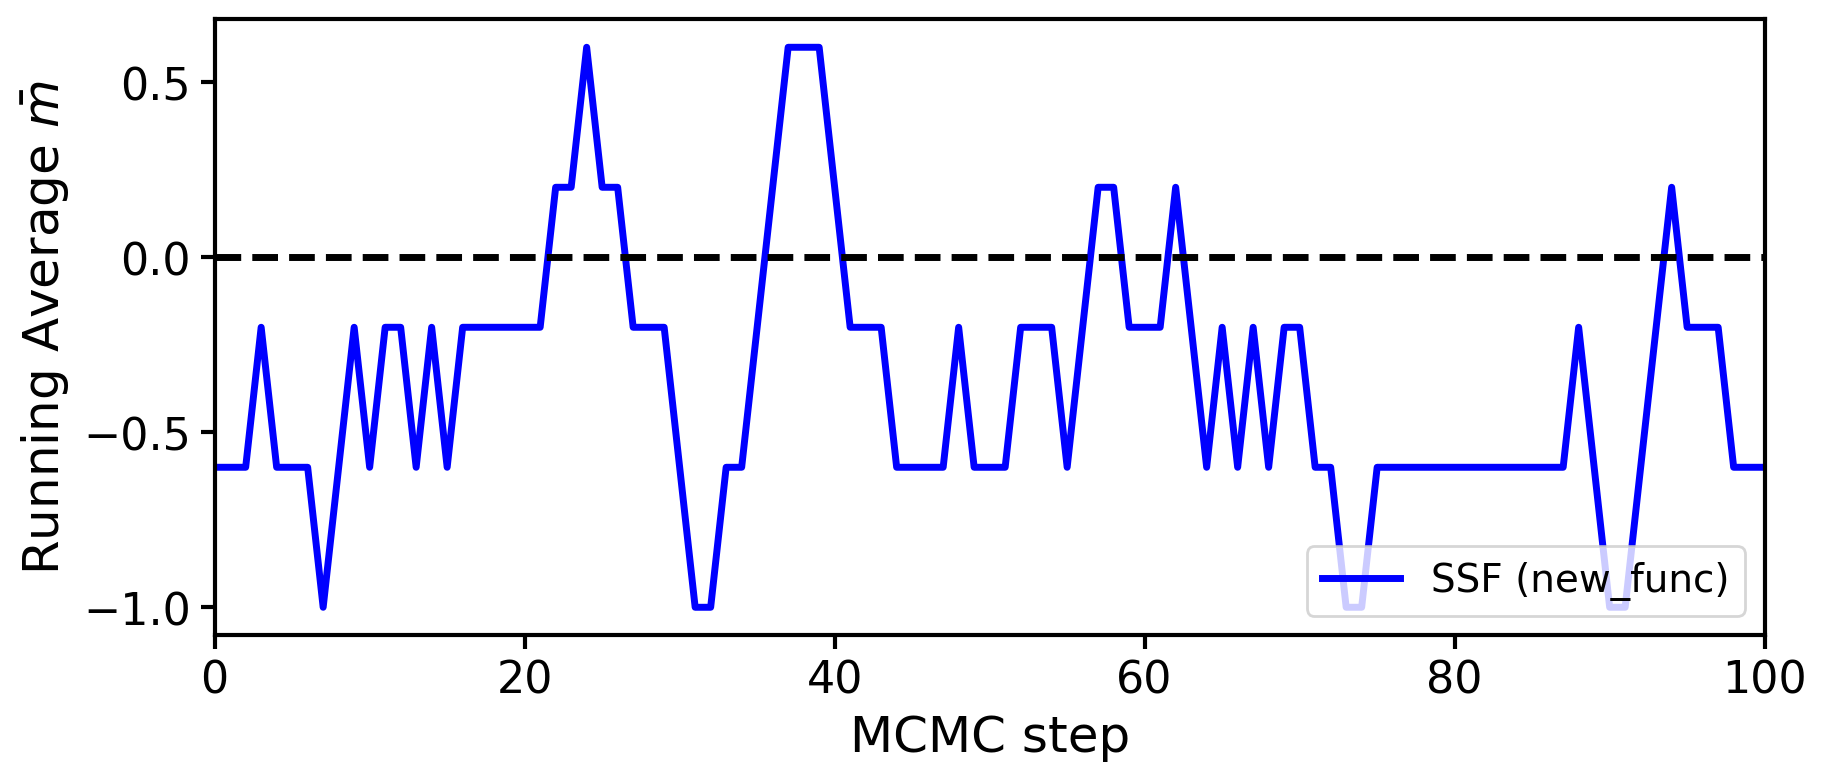

In [45]:
ssf_mag_1 = np.average(state_history_1, axis=1)
ssf_mag_2 = np.average(state_history_2, axis=1)
boltzmann_dist = ising.spin_boltzmann_distribution(instance, beta)
true_val = ising.boltzmann_average_magnetization(n_spin, boltzmann_dist)

capsize = 4
markersize = 7.5
elinewidth = 2.5
capthick = 2.5
linewidth = 2.5
spines = 1.5

fig1_1, ax1_1 = plt.subplots(figsize=(10,4), dpi=200)

ax1_1.spines["top"].set_linewidth(spines)
ax1_1.spines["left"].set_linewidth(spines)
ax1_1.spines["bottom"].set_linewidth(spines)
ax1_1.spines["right"].set_linewidth(spines)

ax1_1.plot(np.arange(n_iter+1), ssf_mag_1, color='blue', linewidth=linewidth, label='SSF (old_func)')
ax1_1.axhline(true_val, color='black', linestyle='--', linewidth=linewidth)

ax1_1.set_xlim(0, n_iter)
#ax1_1.set_ylim(-0.3,0.3)
ax1_1.set_xlabel('MCMC step', fontsize=18)
ax1_1.set_ylabel(r'Running Average $\bar{m}$', fontsize=18)
ax1_1.tick_params(width=1.5, labelsize=16, length=5, labelbottom=True)
ax1_1.tick_params(axis="x", which='major', width=1.5)
ax1_1.legend(fontsize=14, loc='lower right', frameon=True)

fig1_2, ax1_2 = plt.subplots(figsize=(10,4), dpi=200)

ax1_2.spines["top"].set_linewidth(spines)
ax1_2.spines["left"].set_linewidth(spines)
ax1_2.spines["bottom"].set_linewidth(spines)
ax1_2.spines["right"].set_linewidth(spines)

ax1_2.plot(np.arange(n_iter+1), ssf_mag_2, color='blue', linewidth=linewidth, label='SSF (new_func)')
ax1_2.axhline(true_val, color='black', linestyle='--', linewidth=linewidth)

ax1_2.set_xlim(0, n_iter)
#ax121.set_ylim(-0.3,0.3)
ax1_2.set_xlabel('MCMC step', fontsize=18)
ax1_2.set_ylabel(r'Running Average $\bar{m}$', fontsize=18)
ax1_2.tick_params(width=1.5, labelsize=16, length=5, labelbottom=True)
ax1_2.tick_params(axis="x", which='major', width=1.5)
ax1_2.legend(fontsize=14, loc='lower right', frameon=True)

OK!!

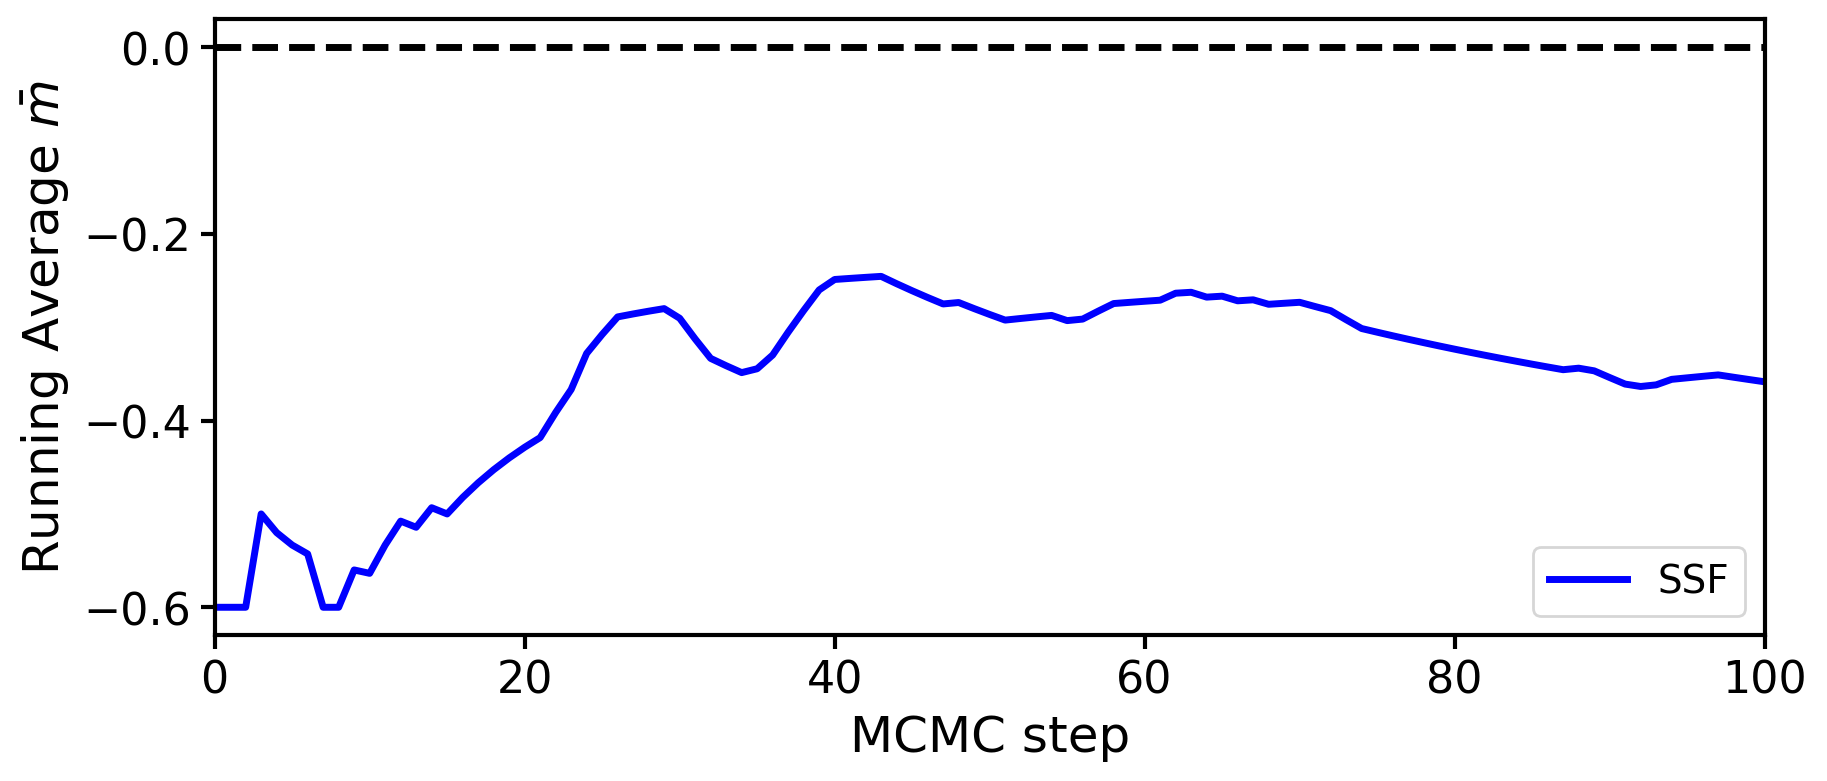

In [46]:
temp = np.arange(1, n_iter+2)
ave_mag_2 = np.cumsum(ssf_mag_2) / temp

fig1_3, ax1_3 = plt.subplots(figsize=(10,4), dpi=200)

ax1_3.spines["top"].set_linewidth(spines)
ax1_3.spines["left"].set_linewidth(spines)
ax1_3.spines["bottom"].set_linewidth(spines)
ax1_3.spines["right"].set_linewidth(spines)

ax1_3.plot(np.arange(n_iter+1), ave_mag_2, color='blue', linewidth=linewidth, label='SSF')
ax1_3.axhline(true_val, color='black', linestyle='--', linewidth=linewidth)

ax1_3.set_xlim(0, n_iter)
ax1_3.set_xlabel('MCMC step', fontsize=18)
ax1_3.set_ylabel(r'Running Average $\bar{m}$', fontsize=18)
ax1_3.tick_params(width=1.5, labelsize=16, length=5, labelbottom=True)
ax1_3.tick_params(axis="x", which='major', width=1.5)
ax1_3.legend(fontsize=14, loc='lower right', frameon=True)

## MADEでのテスト

### 関数定義

In [47]:
def made_update(init_spin, init_log_prob, proposal_history, log_prob_history, instance, beta, n_iter, rng=None):
	if rng == None:
		rng = np.random.default_rng()
    
	n_spin = init_spin.shape[0]
	state_history = np.zeros((n_iter+1, n_spin))
	state_history[0] = init_spin
	acceptance_history = np.zeros(n_iter)

	current_state = init_spin
	current_log_prob = init_log_prob

	for i in range(n_iter):
		# accept or reject the proposal
		next_state, acceptance, flag = mcmc.boltzmann_metropolis_hastings(current_state, proposal_history[i], log_prob_history[i], current_log_prob, instance, beta, rng)

		# update the current_state
		state_history[i+1] = next_state
		acceptance_history[i] = acceptance
		if flag:
			current_state = proposal_history[i]
			current_log_prob = log_prob_history[i]
	
	return state_history, acceptance_history

### テスト

In [48]:
# define instance
n_spin = 10
instance = Ising_model(n_spin, rng, type='SK')
beta = 5.0
n_iter = 1000
n_layers = 5
qaoa_init_para = [0.2705, -0.5899, 0.4803, -0.4492, 0.5074, -0.3559, 0.5646, -0.2643, 0.6397, -0.1291] #文献におけるSKmodelに対するQAOA(p=5)の固定角
qaoa_method = "BFGS"
qaoa_options = {"disp": False, "maxiter": 200, "gtol": 1e-6}
n_train = 2**n_spin
n_test = int(n_train * 0.25)
hidden_size = int(2 * n_spin)
hidden_layers = 2
batchsize = 8
lr = 0.005
n_epochs = 30

In [49]:
random.seed(seed)
generator = torch.Generator().manual_seed(seed)

# optimize QAOA ansatz
prob_hamiltonian = instance.get_hamiltonian()
mixer_hamiltonian = qaoa.generate_X_mixer(n_spin)
qaoa_ansatz = QAOA_ansatz(prob_hamiltonian, mixer_hamiltonian, n_layers)

def qaoa_cost(para):
	return qaoa.cost_QAOA(prob_hamiltonian, qaoa_ansatz, para)

qaoa_opt = scipy.optimize.minimize(qaoa_cost, qaoa_init_para, method=qaoa_method, options=qaoa_options)

# sampling from QAOA distribution
qaoa_opt_data_idx = qaoa.sampling_QAOA(qaoa_ansatz, qaoa_opt.x, n_train+n_test) # optimize parameter
qaoa_opt_data_nd = np.array([qaoa.number_to_binary(qaoa_opt_data_idx[i], n_spin) for i in range(len(qaoa_opt_data_idx))], dtype='float32') # MADEモデルのコードが重み行列をfloat32で記述しているため、データもfloat32に明示的に指定する！
qaoa_opt_data = torch.from_numpy(qaoa_opt_data_nd).to(dtype=torch.float32)
qaoa_opt_traindata, qaoa_opt_testdata = torch.utils.data.random_split(dataset=qaoa_opt_data, lengths=[n_train, n_test], generator=generator)
qaoa_opt_testset = torch.utils.data.DataLoader(qaoa_opt_testdata, batch_size=batchsize, shuffle=False)
qaoa_opt_trainset = torch.utils.data.DataLoader(qaoa_opt_traindata, batch_size=batchsize, shuffle=True)

# learn MADE by QAOA samples
hidden_list = [hidden_size for i in range(hidden_layers)]
model_qaoa_opt = made.MADE(n_spin, hidden_list, n_spin, num_masks=1, natural_ordering=True)
opt_qaoa_opt = torch.optim.Adam(model_qaoa_opt.parameters(), lr=lr, weight_decay=1e-4)
scheduler_qaoa_opt = torch.optim.lr_scheduler.StepLR(opt_qaoa_opt, step_size=45, gamma=0.1)
made.run_train(model_qaoa_opt, qaoa_opt_trainset, qaoa_opt_testset, n_epochs, opt_qaoa_opt, scheduler_qaoa_opt, seed)

# sampling to models and compute the probability of these outputs
#inputs = rng.uniform(0.0, 1.0, size=(n_iter,n_spin)).astype(dtype=np.float32) # bernoulli needs inputs for uniform(0,1)

#opt_qaoa_made_outputs = made.predict(model_qaoa_opt, n_iter)
inputs = np.array([made.number_to_binary(i, n_spin) for i in range(2**n_spin)])
opt_made_prob = made.compute_log_prob(model_qaoa_opt, inputs)
opt_made_prob = np.exp(opt_made_prob)
print(opt_made_prob.shape)
opt_qaoa_made_outputs_idx = rng.choice(2**n_spin, n_iter, p=opt_made_prob)
opt_qaoa_made_outputs = np.array([made.number_to_binary(opt_qaoa_made_outputs_idx[i], n_spin) for i in range(n_iter)])

opt_qaoa_made_outputs = np.array([made.binary_to_spin(opt_qaoa_made_outputs[i]) for i in range(opt_qaoa_made_outputs.shape[0])])
opt_qaoa_made_log_prob = made.compute_log_prob(model_qaoa_opt, opt_qaoa_made_outputs)

(1024,)


#### old version

In [50]:
rng = np.random.default_rng(seed)

# mcmc simulation
state_history_made1 = np.zeros((n_iter+1, n_spin))
init_spin = ising.number_to_spin(rng.integers(0, 2**n_spin), n_spin)
state_history_made1[0] = init_spin

opt_current_state = init_spin
opt_current_log_prob = made.compute_log_prob(model_qaoa_opt, made.spin_to_binary(opt_current_state))

total_count = 0

for j in range(n_iter):
	# made update
	state_history_made1[j+1], acceptance, count = mcmc.boltzmann_metropolis_hastings(opt_current_state,
                                                                            			opt_qaoa_made_outputs[j],
                                                                            			opt_qaoa_made_log_prob[j],
																						opt_current_log_prob,
                                                                            			instance, beta, rng)
	if count:
		opt_current_state = opt_qaoa_made_outputs[j]
		opt_current_log_prob = opt_qaoa_made_log_prob[j]

	total_count += count

#### new version

In [51]:
rng = np.random.default_rng(seed)

# mcmc simulation
opt_qaoa_made_result_2 = np.zeros((n_iter+1, n_spin))
init_spin = ising.number_to_spin(rng.integers(0, 2**n_spin), n_spin)
opt_qaoa_made_result_2[0] = init_spin
init_log_prob = made.compute_log_prob(model_qaoa_opt, made.spin_to_binary(init_spin))

state_history_made2 = made_update(init_spin, init_log_prob, opt_qaoa_made_outputs, opt_qaoa_made_log_prob, instance, beta, n_iter, rng)[0]

#### 確認

84


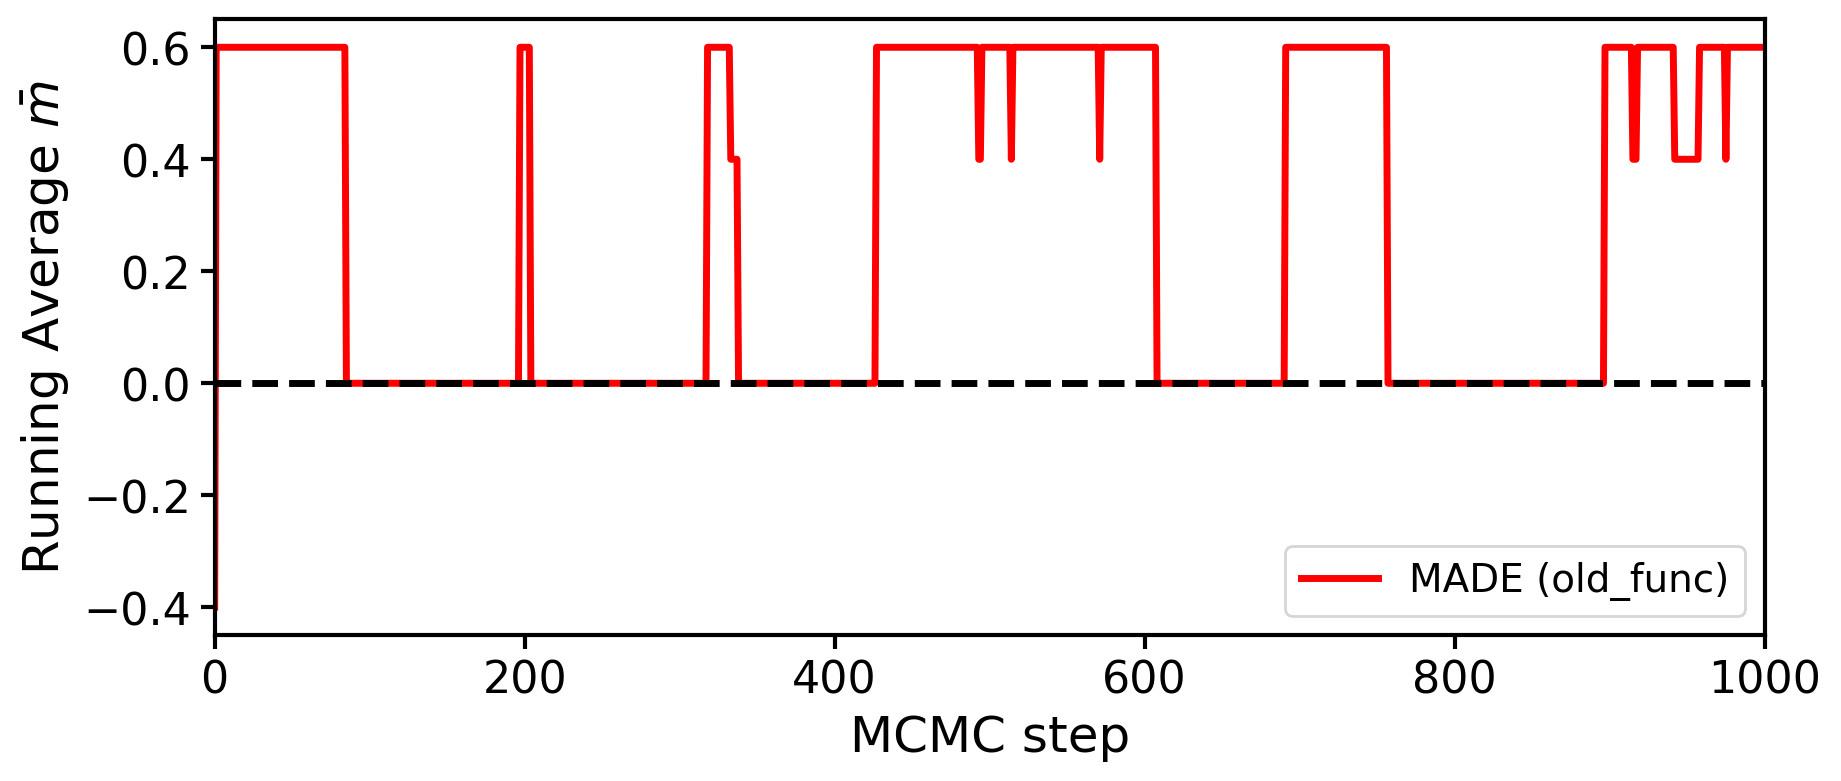

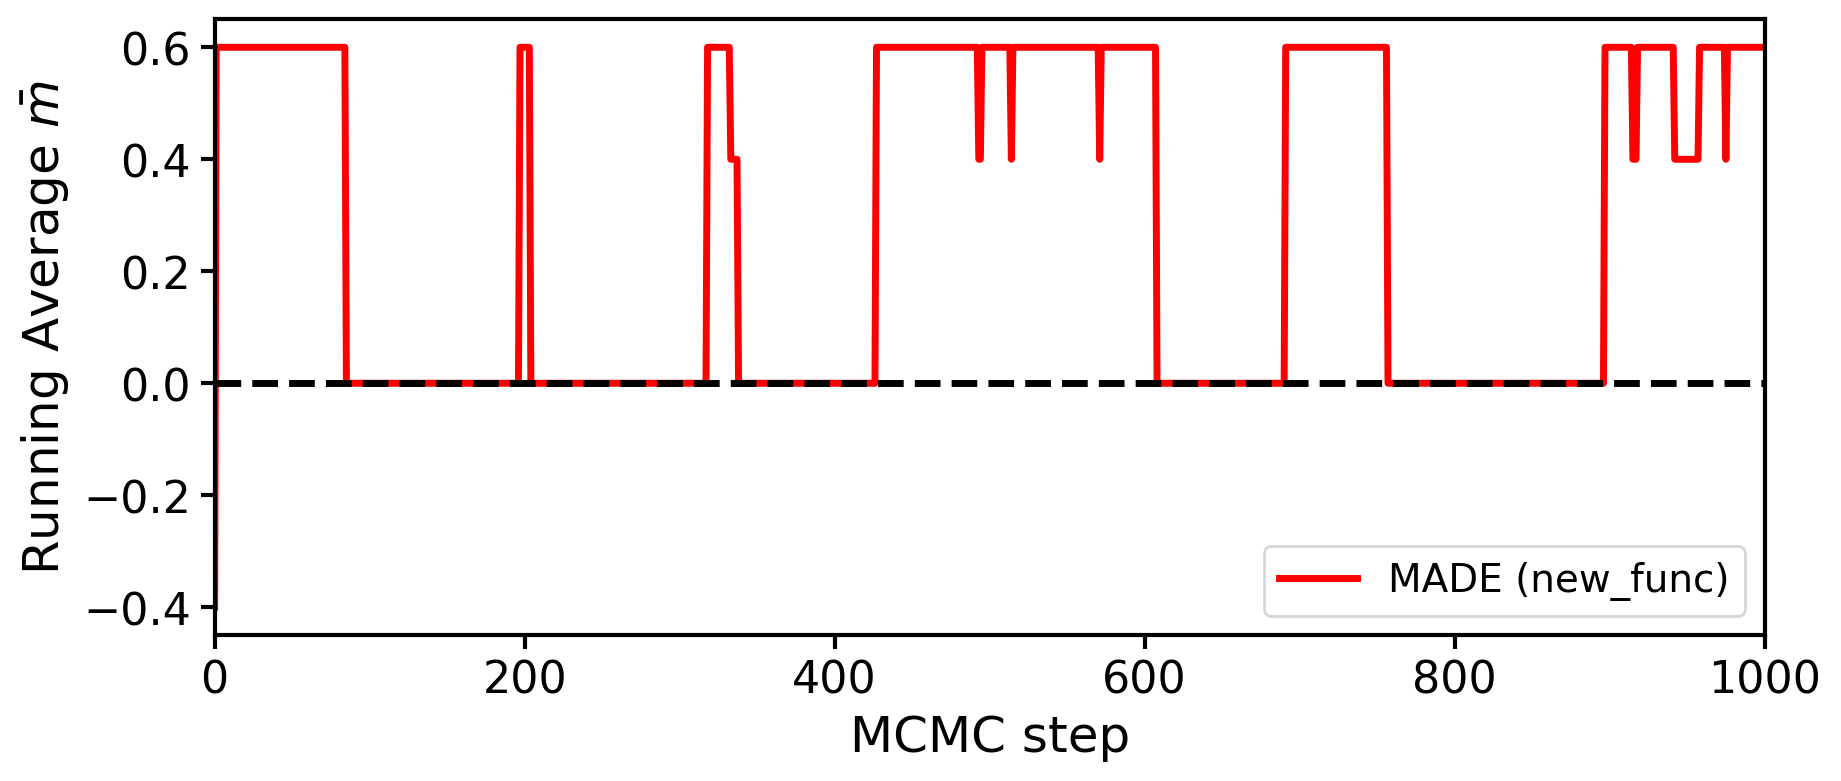

In [52]:
ssf_mag_made1 = np.average(state_history_made1, axis=1)
ssf_mag_made2 = np.average(state_history_made2, axis=1)
boltzmann_dist = ising.spin_boltzmann_distribution(instance, beta)
true_val = ising.boltzmann_average_magnetization(n_spin, boltzmann_dist)

capsize = 4
markersize = 7.5
elinewidth = 2.5
capthick = 2.5
linewidth = 2.5
spines = 1.5

fig2_1, ax2_1 = plt.subplots(figsize=(10,4), dpi=200)

ax2_1.spines["top"].set_linewidth(spines)
ax2_1.spines["left"].set_linewidth(spines)
ax2_1.spines["bottom"].set_linewidth(spines)
ax2_1.spines["right"].set_linewidth(spines)

ax2_1.plot(np.arange(n_iter+1), ssf_mag_made1, color='red', linewidth=linewidth, label='MADE (old_func)')
ax2_1.axhline(true_val, color='black', linestyle='--', linewidth=linewidth)

ax2_1.set_xlim(0, n_iter)
#ax2_1.set_ylim(-0.3,0.3)
ax2_1.set_xlabel('MCMC step', fontsize=18)
ax2_1.set_ylabel(r'Running Average $\bar{m}$', fontsize=18)
ax2_1.tick_params(width=1.5, labelsize=16, length=5, labelbottom=True)
ax2_1.tick_params(axis="x", which='major', width=1.5)
ax2_1.legend(fontsize=14, loc='lower right', frameon=True)

fig2_2, ax2_2 = plt.subplots(figsize=(10,4), dpi=200)

ax2_2.spines["top"].set_linewidth(spines)
ax2_2.spines["left"].set_linewidth(spines)
ax2_2.spines["bottom"].set_linewidth(spines)
ax2_2.spines["right"].set_linewidth(spines)

ax2_2.plot(np.arange(n_iter+1), ssf_mag_made2, color='red', linewidth=linewidth, label='MADE (new_func)')
ax2_2.axhline(true_val, color='black', linestyle='--', linewidth=linewidth)

ax2_2.set_xlim(0, n_iter)
#ax121.set_ylim(-0.3,0.3)
ax2_2.set_xlabel('MCMC step', fontsize=18)
ax2_2.set_ylabel(r'Running Average $\bar{m}$', fontsize=18)
ax2_2.tick_params(width=1.5, labelsize=16, length=5, labelbottom=True)
ax2_2.tick_params(axis="x", which='major', width=1.5)
ax2_2.legend(fontsize=14, loc='lower right', frameon=True)

print(total_count)

#### 磁化平均

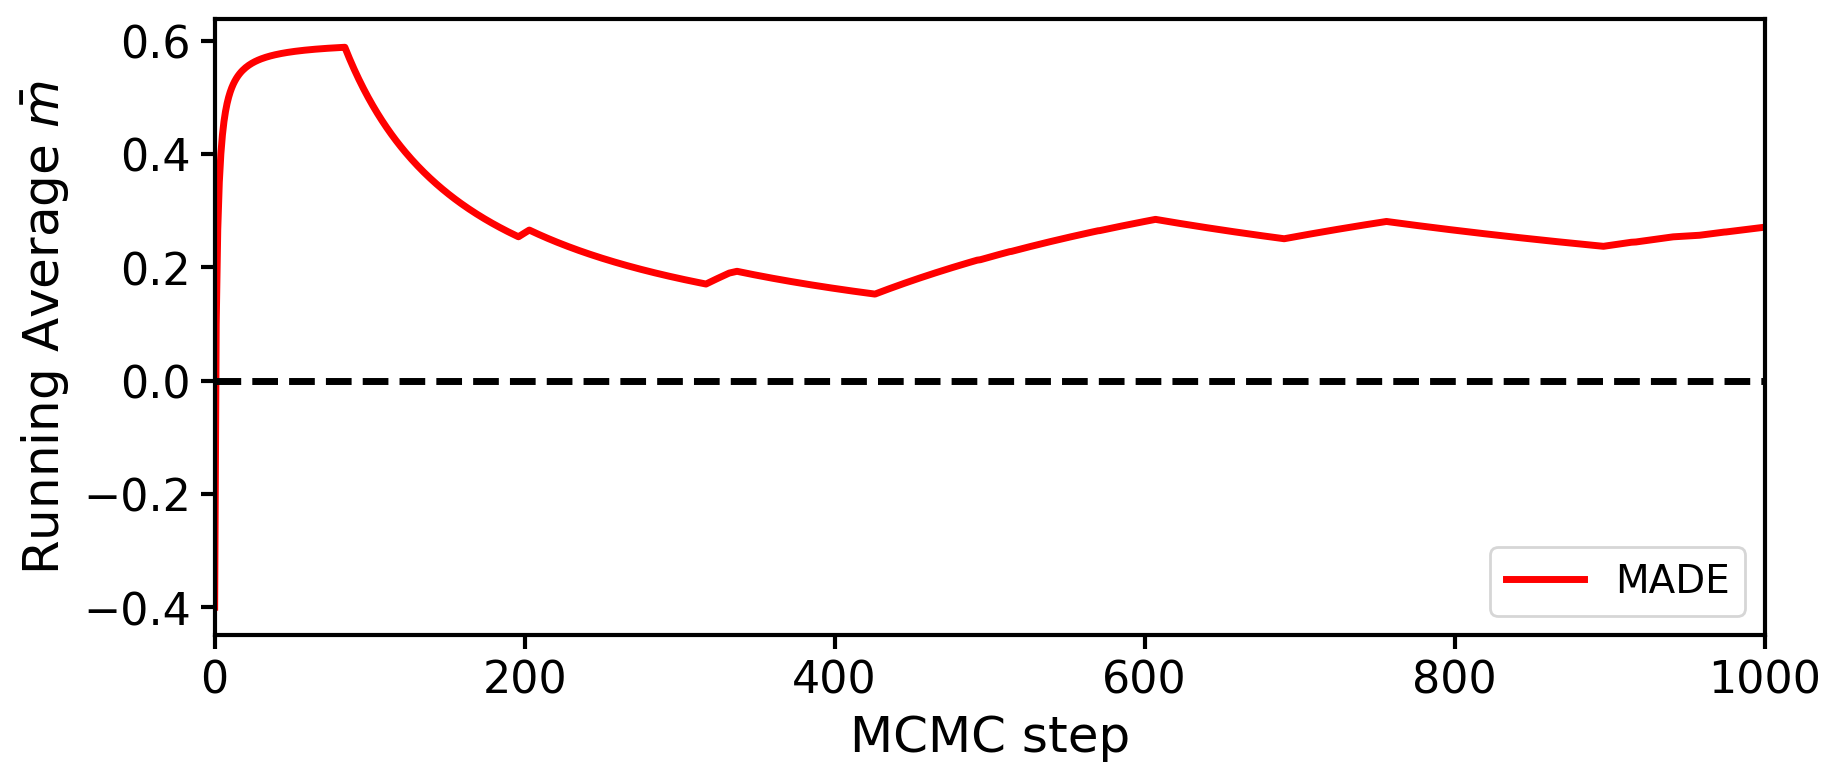

In [53]:
temp = np.arange(1, n_iter+2)
ave_mag_made2 = np.cumsum(ssf_mag_made2) / temp

fig2_3, ax2_3 = plt.subplots(figsize=(10,4), dpi=200)

ax2_3.spines["top"].set_linewidth(spines)
ax2_3.spines["left"].set_linewidth(spines)
ax2_3.spines["bottom"].set_linewidth(spines)
ax2_3.spines["right"].set_linewidth(spines)

ax2_3.plot(np.arange(n_iter+1), ave_mag_made2, color='red', linewidth=linewidth, label='MADE')
ax2_3.axhline(true_val, color='black', linestyle='--', linewidth=linewidth)

ax2_3.set_xlim(0, n_iter)
#ax131.set_ylim(-0.3,0.3)
ax2_3.set_xlabel('MCMC step', fontsize=18)
ax2_3.set_ylabel(r'Running Average $\bar{m}$', fontsize=18)
ax2_3.tick_params(width=1.5, labelsize=16, length=5, labelbottom=True)
ax2_3.tick_params(axis="x", which='major', width=1.5)
ax2_3.legend(fontsize=14, loc='lower right', frameon=True)

#### MADE提案分布の詳細

In [54]:
inputs = np.array([made.number_to_binary(i, n_spin) for i in range(2**n_spin)])
made_dist = made.compute_log_prob(model_qaoa_opt, inputs)
made_dist = np.exp(made_dist)

print(np.sort(made_dist))
print(np.sum(made_dist))

[1.6215778e-09 2.4173561e-09 5.0799458e-09 ... 8.3963975e-02 1.1950594e-01
 1.2251502e-01]
1.0000001


## MADEモデルについて

### MADE旧バージョン

In [55]:
import torch.nn as nn
import torch.nn.functional as F

class MaskedLinear(nn.Linear):
    """ same as Linear except has a configurable mask on the weights """
    
    def __init__(self, in_features, out_features, bias=True):
        super().__init__(in_features, out_features, bias)        
        self.register_buffer('mask', torch.ones(out_features, in_features))
        
    def set_mask(self, mask):
        self.mask.data.copy_(torch.from_numpy(mask.astype(np.uint8).T))
        
    def forward(self, input):
        return F.linear(input, self.mask * self.weight, self.bias)

class MADE_old(nn.Module):
    def __init__(self, nin, hidden_sizes, nout, num_masks=1, natural_ordering=False, seed=0):
        """
        nin: integer; number of inputs
        hidden sizes: a list of integers; number of units in hidden layers
        nout: integer; number of outputs, which usually collectively parameterize some kind of 1D distribution
              note: if nout is e.g. 2x larger than nin (perhaps the mean and std), then the first nin
              will be all the means and the second nin will be stds. i.e. output dimensions depend on the
              same input dimensions in "chunks" and should be carefully decoded downstream appropriately.
              the output of running the tests for this file makes this a bit more clear with examples.
        num_masks: can be used to train ensemble over orderings/connections
        natural_ordering: force natural ordering of dimensions, don't use random permutations
        """
        
        super().__init__()
        self.nin = nin
        self.nout = nout
        self.hidden_sizes = hidden_sizes
        assert self.nout % self.nin == 0, "nout must be integer multiple of nin"
        
        # define a simple MLP neural net
        self.net = []
        hs = [nin] + hidden_sizes + [nout]
        for h0,h1 in zip(hs, hs[1:]):
            self.net.extend([
                    MaskedLinear(h0, h1),
                    nn.LeakyReLU(), # change ReLU to LeakyReLU
                ])
        self.net.pop() # pop the last ReLU for the output layer
        self.net.append(nn.Sigmoid()) # add the sigmoid for the output layer
        self.net = nn.Sequential(*self.net)
        
        # seeds for orders/connectivities of the model ensemble
        self.natural_ordering = natural_ordering
        self.num_masks = num_masks
        self.seed = seed # for cycling through num_masks orderings
        
        self.m = {}
        self.update_masks() # builds the initial self.m connectivity
        # note, we could also precompute the masks and cache them, but this
        # could get memory expensive for large number of masks.
        
    def update_masks(self):
        if self.m and self.num_masks == 1: return # only a single seed, skip for efficiency
        L = len(self.hidden_sizes)
        
        # fetch the next seed and construct a random stream
        rng = np.random.RandomState(self.seed)
        self.seed = (self.seed + 1) % self.num_masks
        
        # sample the order of the inputs and the connectivity of all neurons
        self.m[-1] = np.arange(self.nin) if self.natural_ordering else rng.permutation(self.nin)
        for l in range(L):
            self.m[l] = rng.randint(self.m[l-1].min(), self.nin-1, size=self.hidden_sizes[l])
        
        # construct the mask matrices
        masks = [self.m[l-1][:,None] <= self.m[l][None,:] for l in range(L)]
        masks.append(self.m[L-1][:,None] < self.m[-1][None,:])
        
        # handle the case where nout = nin * k, for integer k > 1
        if self.nout > self.nin:
            k = int(self.nout / self.nin)
            # replicate the mask across the other outputs
            masks[-1] = np.concatenate([masks[-1]]*k, axis=1)
        
        # set the masks in all MaskedLinear layers
        layers = [l for l in self.net.modules() if isinstance(l, MaskedLinear)]
        for l,m in zip(layers, masks):
            l.set_mask(m)
    
    def forward(self, x):
        return self.net(x)
    
# training function
def set_seed(seed):
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def run_epoch(model, split, dataset, opt, seed=None):
	if seed != None:
		set_seed(seed)
    
	torch.set_grad_enabled(split=='train') # enable/disable grad for efficiency of forwarding test batches

	model.train() if split == 'train' else model.eval()
	x = dataset
	for i, xb in enumerate(x):
		# get the logits, potentially run the same batch a number of times, resampling each time
		model.update_masks()

		# forward the model
		xbhat = model(xb)

		# evaluate the binary cross entropy loss
		criterion = nn.BCELoss()
		loss = criterion(xbhat, xb)

		# backward/update
		if split == 'train':
			opt.zero_grad()
			loss.backward()
			opt.step()

	return loss

def run_train(model, train_data, test_data, n_epochs, opt, scheduler=None, seed=None):
	if seed != None:
		set_seed(seed)

	train_loss = []
	test_loss = []

	for epoch in range(n_epochs):
		test_loss.append(run_epoch(model, 'test', test_data, opt))
		train_loss.append(run_epoch(model, 'train', train_data, opt))
		if scheduler:
			scheduler.step()
	
	test_loss.append(run_epoch(model, 'test', test_data, opt))

	return train_loss, test_loss

# sampling
def predict(model, inputs: np.ndarray):
    n = model.nin
    
    # convert ndarray to torch.tensor
    inputs_th = torch.from_numpy(inputs.copy()).to(dtype=torch.float32)
    
    # apply model and sampling
    xbhat = model(inputs_th)
    outputs_th = torch.bernoulli(xbhat)
    outputs = outputs_th.detach().numpy()
    
    return outputs

### 学習テスト

#### インスタンス準備

In [56]:
# setting
n_spin = 8
instance = Ising_model(n_spin, rng, type='SK')
beta = 5.0
n_iter = 1000
n_layers = 5
qaoa_init_para = [0.2705, -0.5899, 0.4803, -0.4492, 0.5074, -0.3559, 0.5646, -0.2643, 0.6397, -0.1291] #文献におけるSKmodelに対するQAOA(p=5)の固定角
qaoa_method = "BFGS"
qaoa_options = {"disp": False, "maxiter": 200, "gtol": 1e-6}

n_train = 2**n_spin
n_test = int(n_train * 0.25)

hidden_size = int(2 * n_spin)
hidden_layers = 2
hidden_list = [hidden_size for i in range(hidden_layers)]

batchsize = 8
lr = 0.005
n_epochs = 30

random.seed(seed)
generator = torch.Generator().manual_seed(seed)

# optimize QAOA ansatz
prob_hamiltonian = instance.get_hamiltonian()
mixer_hamiltonian = qaoa.generate_X_mixer(n_spin)
qaoa_ansatz = QAOA_ansatz(prob_hamiltonian, mixer_hamiltonian, n_layers)

def qaoa_cost(para):
	return qaoa.cost_QAOA(prob_hamiltonian, qaoa_ansatz, para)

qaoa_opt = scipy.optimize.minimize(qaoa_cost, qaoa_init_para, method=qaoa_method, options=qaoa_options)

# sampling from QAOA distribution
qaoa_opt_data_idx = qaoa.sampling_QAOA(qaoa_ansatz, qaoa_opt.x, n_train+n_test) # optimize parameter
qaoa_opt_data_nd = np.array([qaoa.number_to_binary(qaoa_opt_data_idx[i], n_spin) for i in range(len(qaoa_opt_data_idx))], dtype='float32') # MADEモデルのコードが重み行列をfloat32で記述しているため、データもfloat32に明示的に指定する！
qaoa_opt_data = torch.from_numpy(qaoa_opt_data_nd).to(dtype=torch.float32)
qaoa_opt_traindata, qaoa_opt_testdata = torch.utils.data.random_split(dataset=qaoa_opt_data, lengths=[n_train, n_test], generator=generator)
qaoa_opt_testset = torch.utils.data.DataLoader(qaoa_opt_testdata, batch_size=batchsize, shuffle=False)
qaoa_opt_trainset = torch.utils.data.DataLoader(qaoa_opt_traindata, batch_size=batchsize, shuffle=True)

#### old version

In [57]:
made.set_seed(seed)

# learn MADE by QAOA samples
model_qaoa_opt_1 = MADE_old(n_spin, hidden_list, n_spin, num_masks=1, natural_ordering=True)
opt_qaoa_opt_1 = torch.optim.Adam(model_qaoa_opt_1.parameters(), lr=lr, weight_decay=1e-4)
scheduler_qaoa_opt_1 = torch.optim.lr_scheduler.StepLR(opt_qaoa_opt_1, step_size=45, gamma=0.1)
qaoa_opt_train_loss_1, qaoa_opt_test_loss_1 = run_train(model_qaoa_opt_1, qaoa_opt_trainset, qaoa_opt_testset, n_epochs, opt_qaoa_opt_1, scheduler_qaoa_opt_1, seed)

# sampling to models and compute the probability of these outputs
inputs = rng.integers(2, size=(n_iter,n_spin)).astype(dtype=np.float32)

opt_qaoa_made_outputs_1 = predict(model_qaoa_opt_1, inputs)
opt_qaoa_made_outputs_1 = np.array([made.binary_to_spin(opt_qaoa_made_outputs_1[i]) for i in range(opt_qaoa_made_outputs_1.shape[0])])

#### new version

In [58]:
made.set_seed(seed)

# learn MADE by QAOA samples
model_qaoa_opt_2 = made.MADE(n_spin, hidden_list, n_spin, num_masks=1, natural_ordering=True)
opt_qaoa_opt_2 = torch.optim.Adam(model_qaoa_opt_2.parameters(), lr=lr, weight_decay=1e-4)
scheduler_qaoa_opt_2 = torch.optim.lr_scheduler.StepLR(opt_qaoa_opt_2, step_size=45, gamma=0.1)
qaoa_opt_train_loss_2, qaoa_opt_test_loss_2 = made.run_train(model_qaoa_opt_2, qaoa_opt_trainset, qaoa_opt_testset, n_epochs, opt_qaoa_opt_2, scheduler_qaoa_opt_2, seed)

# sampling to models and compute the probability of these outputs
inputs = rng.integers(2, size=(n_iter,n_spin)).astype(dtype=np.float32)

opt_qaoa_made_outputs_2 = made.predict(model_qaoa_opt_2, inputs)
opt_qaoa_made_outputs_2 = np.array([made.binary_to_spin(opt_qaoa_made_outputs_2[i]) for i in range(opt_qaoa_made_outputs_2.shape[0])])

TypeError: zeros() received an invalid combination of arguments - got (numpy.ndarray, int), but expected one of:
 * (tuple of ints size, *, tuple of names names, torch.dtype dtype, torch.layout layout, torch.device device, bool pin_memory, bool requires_grad)
 * (tuple of ints size, *, Tensor out, torch.dtype dtype, torch.layout layout, torch.device device, bool pin_memory, bool requires_grad)


#### 学習結果

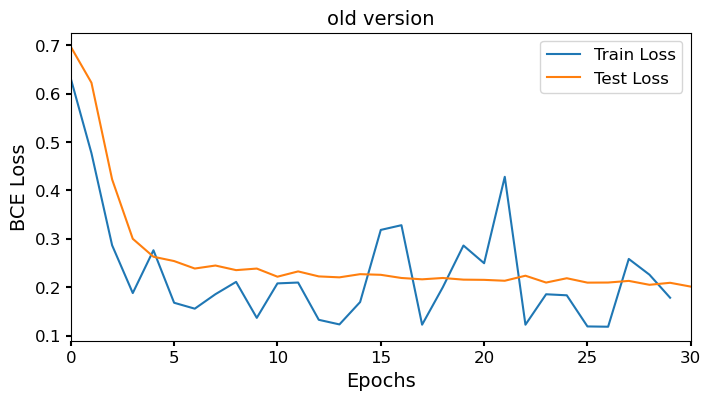

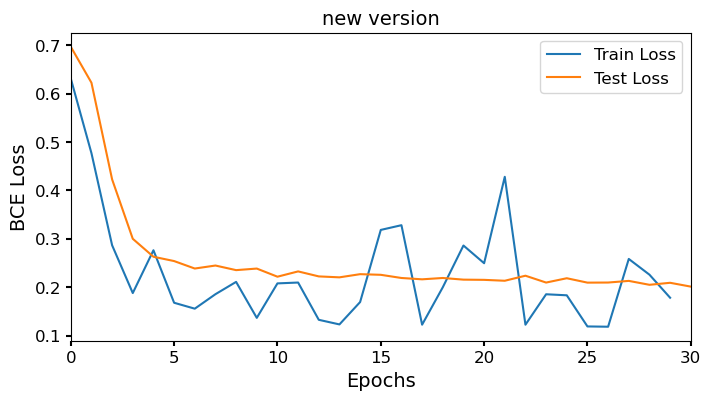

In [ ]:
fig3_1, ax3_1 = plt.subplots(figsize=(8,4), dpi=100)

# QAOA (optimized)
ax3_1.plot(np.arange(n_epochs), qaoa_opt_train_loss_1, label='Train Loss')
ax3_1.plot(np.arange(n_epochs+1), qaoa_opt_test_loss_1, label='Test Loss')
ax3_1.set_xlabel("Epochs", fontsize=14)
ax3_1.set_ylabel("BCE Loss", fontsize=14)
ax3_1.tick_params(width=1.5, labelsize=12)
ax3_1.set_xlim(0, n_epochs)
ax3_1.set_title("old version", fontsize=14)
ax3_1.legend(fontsize=12)

fig3_2, ax3_2 = plt.subplots(figsize=(8,4), dpi=100)

# QAOA (optimized)
ax3_2.plot(np.arange(n_epochs), qaoa_opt_train_loss_2, label='Train Loss')
ax3_2.plot(np.arange(n_epochs+1), qaoa_opt_test_loss_2, label='Test Loss')
ax3_2.set_xlabel("Epochs", fontsize=14)
ax3_2.set_ylabel("BCE Loss", fontsize=14)
ax3_2.tick_params(width=1.5, labelsize=12)
ax3_2.set_xlim(0, n_epochs)
ax3_2.set_title("new version", fontsize=14)
ax3_2.legend(fontsize=12)

In [59]:
a = np.ones(10)
b = np.cumsum(a)
print(a)
print(b)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
